Imports:

In [9]:
# %pip install pandas
# %pip install matplotlib
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# %pip install scikit-learn

In [1]:
# Imports:

import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import cv2
import random




In [2]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


True
NVIDIA GeForce RTX 3060 Ti


Load the data

In [3]:
import os
import numpy as np
from PIL import Image
from sklearn.datasets import fetch_lfw_people


def build_image_index(data_path):
    index = {}
    for person_dir in os.listdir(data_path):
        person_path = os.path.join(data_path, person_dir)
        if not os.path.isdir(person_path):
            continue
        images = sorted(os.listdir(person_path))
        for i, img_name in enumerate(images):
            index[(person_dir.replace('_', ' '), i + 1)] = os.path.join(person_path, img_name)
    return index


def get_image(path_dict, name, idx):
    key = (name.replace('_', ' '), idx)
    if key not in path_dict:
        return None
    img_path = path_dict[key]
    try:
        img = Image.open(img_path).convert('L').resize((94, 125))  # match shape (1, 125, 94)
        return np.array(img, dtype=np.uint8)
    except:
        return None


def load_lfw_pairs_file(file_path, path_dict):
    pairs, labels = [], []
    with open(file_path, 'r') as f:
        lines = f.readlines()[1:]
        for line in lines:
            parts = line.strip().split()
            if len(parts) == 3:
                name, idx1, idx2 = parts[0], int(parts[1]), int(parts[2])
                img1 = get_image(path_dict, name, idx1)
                img2 = get_image(path_dict, name, idx2)
                label = 1.0
            elif len(parts) == 4:
                name1, idx1, name2, idx2 = parts[0], int(parts[1]), parts[2], int(parts[3])
                img1 = get_image(path_dict, name1, idx1)
                img2 = get_image(path_dict, name2, idx2)
                label = 0.0
            else:
                continue

            if img1 is not None and img2 is not None:
                pairs.append((img1, img2))
                labels.append(label)
    return np.array(pairs), np.array(labels, dtype=np.float32)

In [ ]:


#---------------------------------------------------
# Using this, isnt the same as below, it alows for more data to be downloaded,
#  and used differntly then expected.
#--------------------------------------------------


# from sklearn.datasets import fetch_lfw_people

# # Download and load the dataset
# lfw_people = fetch_lfw_people(min_faces_per_person=5, resize=1)

# # Get the images and labels
# X = lfw_people.data
# y = lfw_people.target

# # Split into training and testing sets
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
from torch.utils.data import DataLoader

# Fetch the dataset (ensure images are downloaded)
# lfw = fetch_lfw_people(download_if_missing=True, color=False, funneled=True)

lfw_path = "lfw2"

# Build image index
image_paths = build_image_index(lfw_path)

# Load the pair data from files you uploaded
train_pairs, train_labels = load_lfw_pairs_file('pairsDevTrain.txt', image_paths)
test_pairs, test_labels = load_lfw_pairs_file('pairsDevTest.txt', image_paths)

print("Train pairs shape:", train_pairs.shape)
print("Train labels shape:", train_labels.shape)
print("Test pairs shape:", test_pairs.shape)
print("Test labels shape:", test_labels.shape)


Train pairs shape: (2200, 2, 125, 94)
Train labels shape: (2200,)
Test pairs shape: (1000, 2, 125, 94)
Test labels shape: (1000,)


# EDA

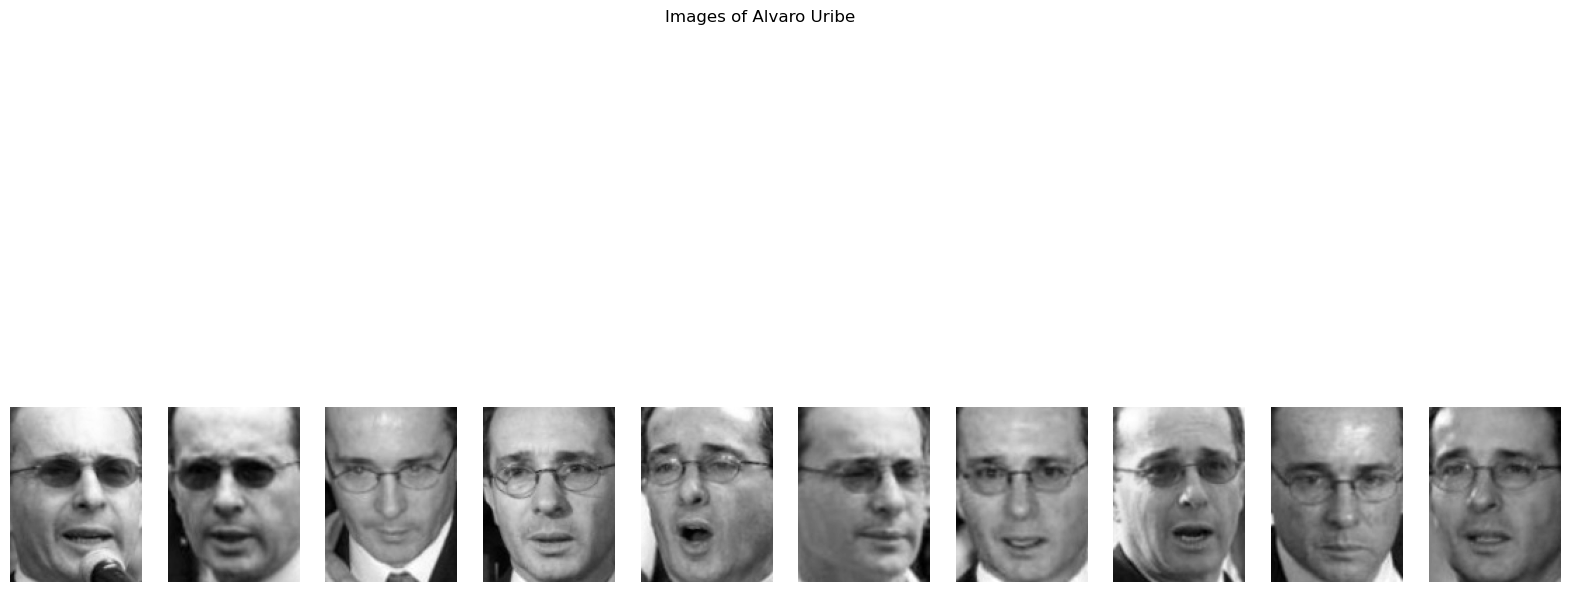

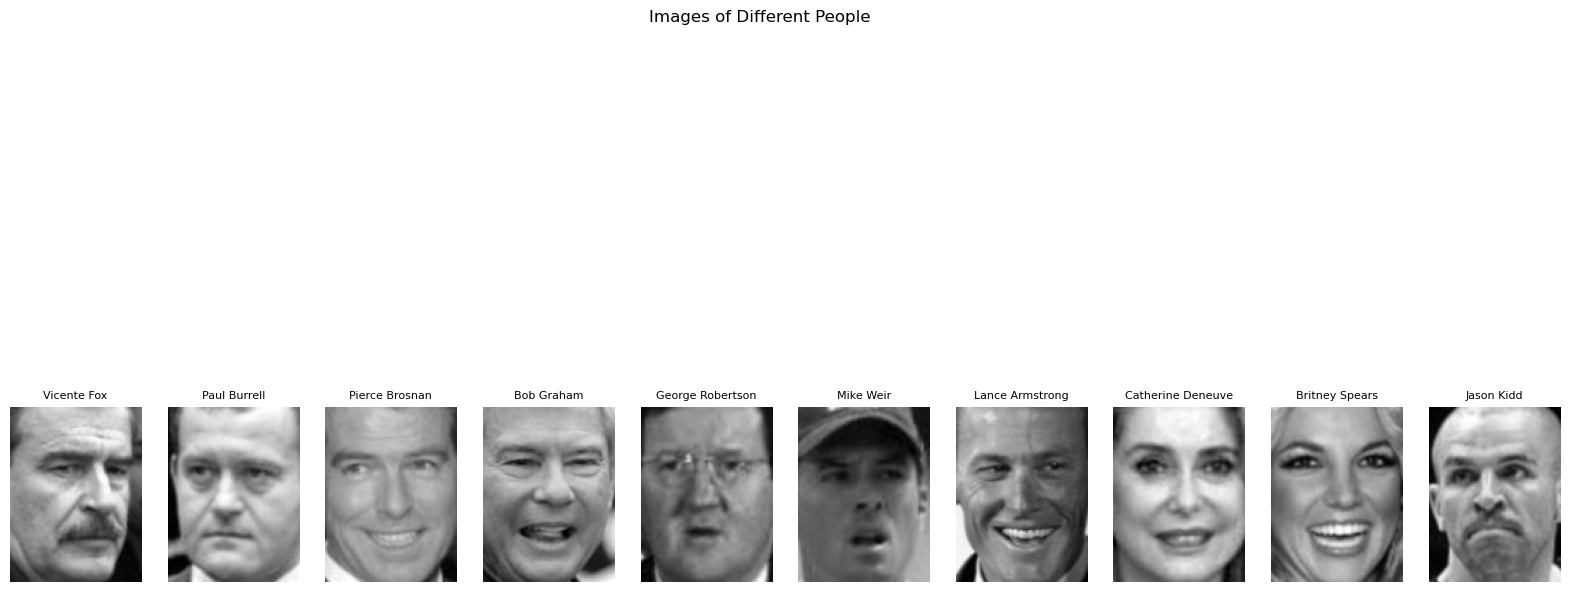

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Get some info from the dataset
target_names = lfw_people.target_names
images = lfw_people.images
n_samples, h, w = images.shape

# Show a few images of the same person
def show_images_of_same_person(label_id, num=5):
    idx = np.where(y == label_id)[0][:num]
    fig, axs = plt.subplots(1, num, figsize=(20, 10))
    fig.suptitle(f"Images of {target_names[label_id]}")
    for i, ax in zip(idx, axs):
        ax.imshow(images[i], cmap='gray')
        ax.axis('off')
    plt.show()

# Show images of different people
def show_images_of_different_people(num=5):
    shown_labels = set()
    fig, axs = plt.subplots(1, num, figsize=(20, 10))
    i = 0
    shown = 0
    while shown < num and i < len(y):
        if y[i] not in shown_labels:
            axs[shown].imshow(images[i], cmap='gray')
            axs[shown].set_title(target_names[y[i]], fontsize=8)
            axs[shown].axis('off')
            shown_labels.add(y[i])
            shown += 1
        i += 1
    plt.suptitle("Images of Different People")
    plt.show()

# Example usage
show_images_of_same_person(label_id=12, num=10)  # Show 5 images of person 0
show_images_of_different_people(num=10)         # Show 5 images of different people


Training Set:
Showing 5 'same' pairs from the Training set:


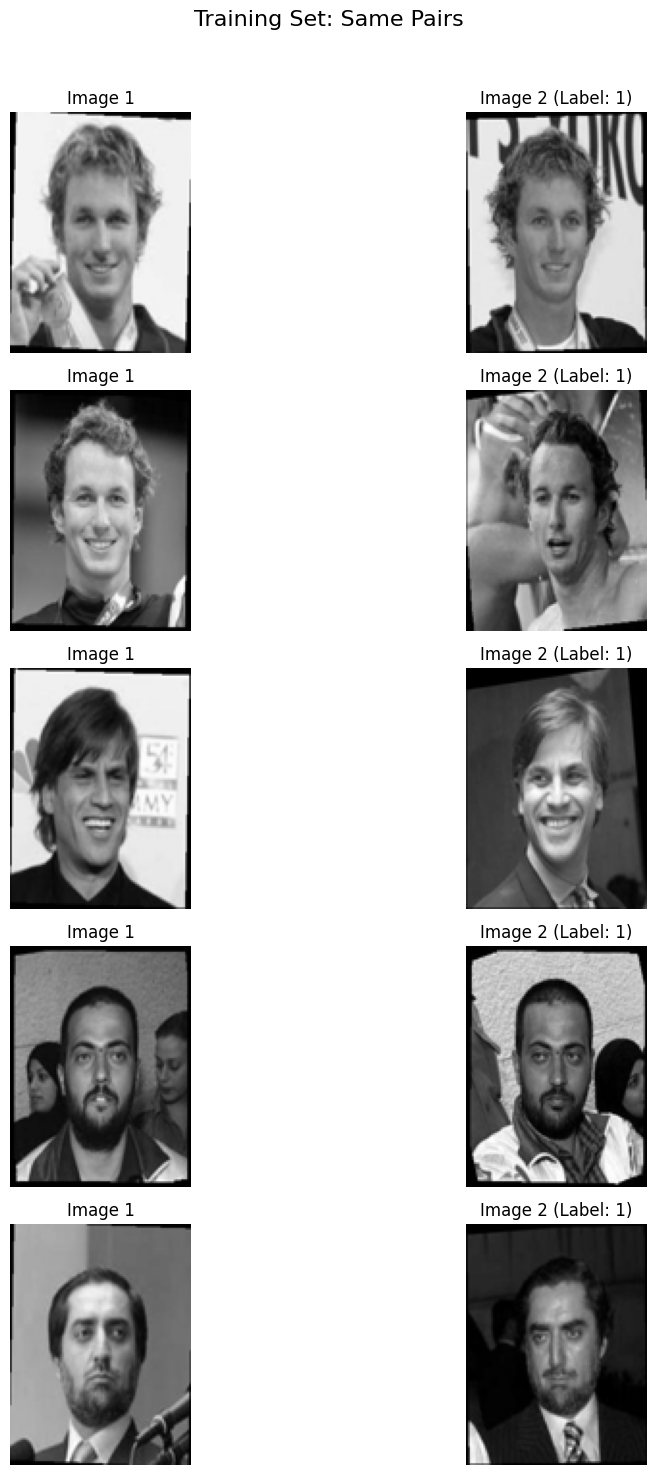

Showing 5 'different' pairs from the Training set:


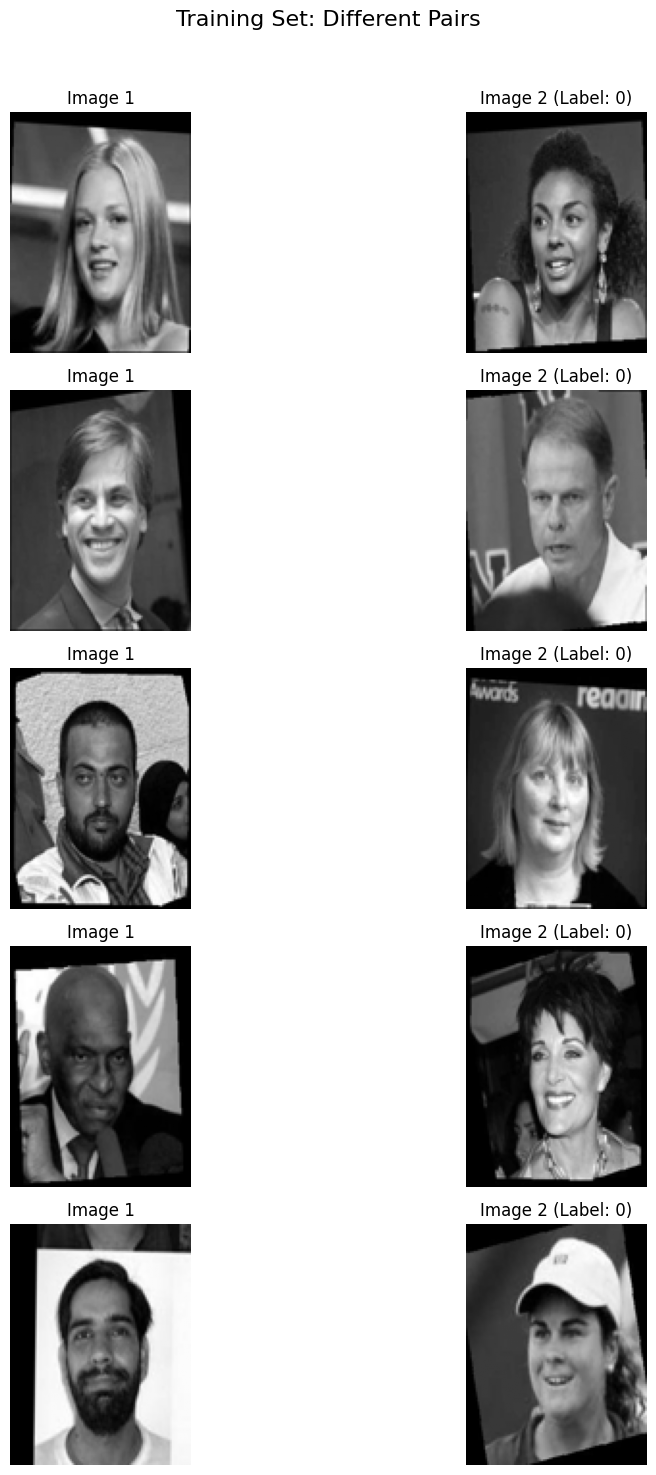

Test Set:
Showing 5 'same' pairs from the Test set:


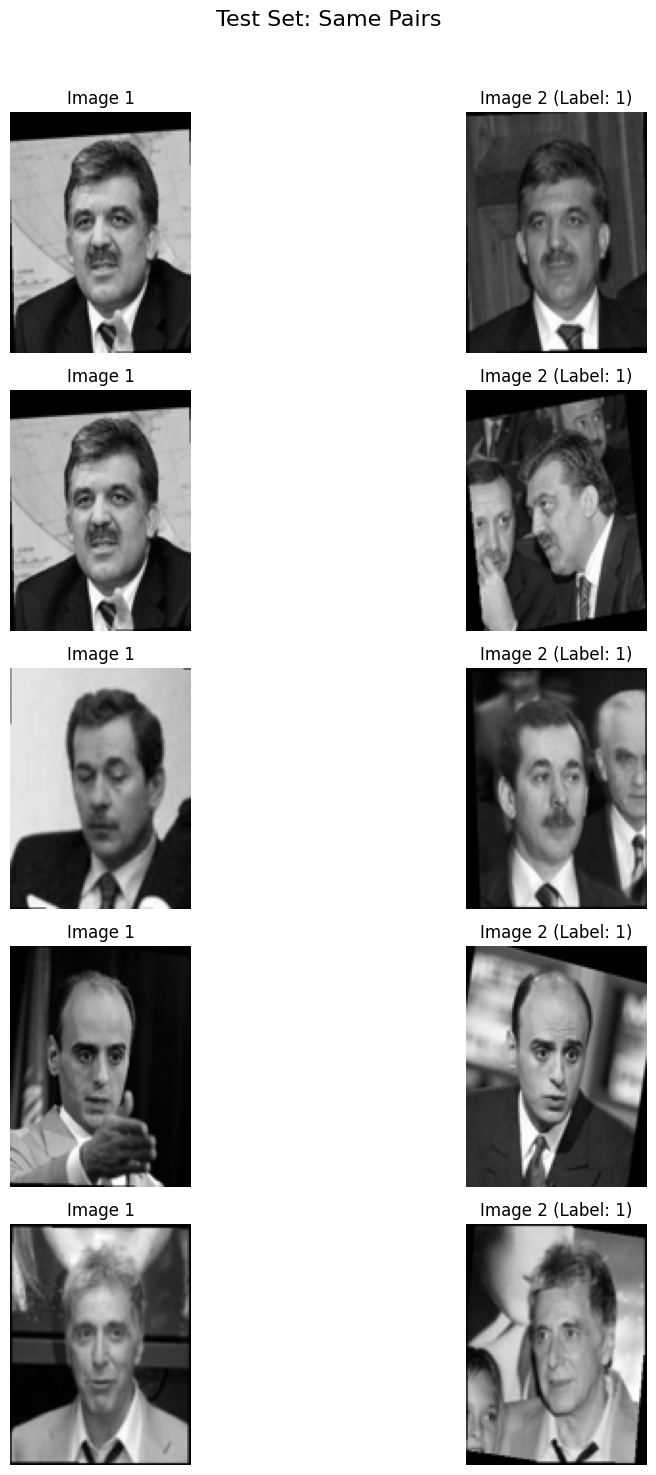

Showing 5 'different' pairs from the Test set:


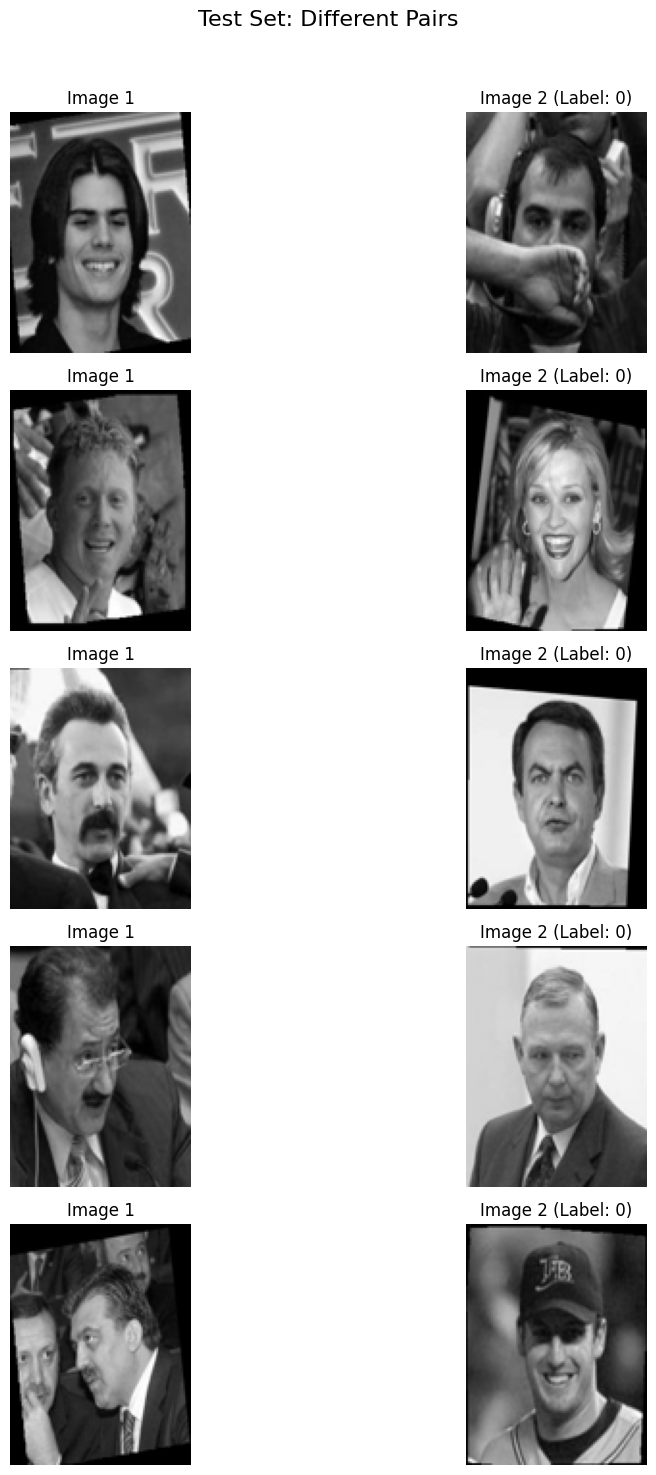

Training Set: 1100 same pairs, 1100 different pairs
Test Set: 500 same pairs, 500 different pairs


In [13]:
# Improved EDA for pairs
def show_pair_samples(pairs, labels, num_samples=5, title="Pairs"):
    """
    Display pairs of images side by side with their labels.

    Args:
        pairs (np.array): Array of image pairs.
        labels (np.array): Array of labels (1 for same, 0 for different).
        num_samples (int): Number of pairs to display.
        title (str): Title for the plot.
    """
    fig, axs = plt.subplots(num_samples, 2, figsize=(12, 3 * num_samples))
    fig.suptitle(title, fontsize=16)
    for i in range(num_samples):
        img1, img2 = pairs[i]
        axs[i, 0].imshow(img1, cmap='gray')
        axs[i, 0].axis('off')
        axs[i, 0].set_title("Image 1")
        axs[i, 1].imshow(img2, cmap='gray')
        axs[i, 1].axis('off')
        axs[i, 1].set_title(f"Image 2 (Label: {int(labels[i])})")
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
    plt.show()


def show_samples_by_class(pairs, labels, num_samples=5, dataset_name="Training"):
    """
    Display pairs of images for both classes (same and different).

    Args:
        pairs (np.array): Array of image pairs.
        labels (np.array): Array of labels (1 for same, 0 for different).
        num_samples (int): Number of pairs to display for each class.
        dataset_name (str): Name of the dataset (e.g., "Training" or "Test").
    """
    # Separate pairs by class
    same_pairs = pairs[labels == 1]
    different_pairs = pairs[labels == 0]

    print(f"Showing {num_samples} 'same' pairs from the {dataset_name} set:")
    show_pair_samples(same_pairs[:num_samples], np.ones(num_samples), title=f"{dataset_name} Set: Same Pairs")

    print(f"Showing {num_samples} 'different' pairs from the {dataset_name} set:")
    show_pair_samples(different_pairs[:num_samples], np.zeros(num_samples), title=f"{dataset_name} Set: Different Pairs")


# Show samples from the training set
print("Training Set:")
show_samples_by_class(train_pairs, train_labels, num_samples=5, dataset_name="Training")

# Show samples from the test set
print("Test Set:")
show_samples_by_class(test_pairs, test_labels, num_samples=5, dataset_name="Test")

# Count the number of same and different pairs in both sets
num_same_train = np.sum(train_labels == 1)
num_different_train = np.sum(train_labels == 0)
num_same_test = np.sum(test_labels == 1)
num_different_test = np.sum(test_labels == 0)

print(f"Training Set: {num_same_train} same pairs, {num_different_train} different pairs")
print(f"Test Set: {num_same_test} same pairs, {num_different_test} different pairs")

# Code implementation

Code to create the pairs for the training

In [ ]:
# import numpy as np
# from sklearn.utils import check_random_state

# def create_image_pairs(X, y, positive_ratio=0.5, num_pairs=10_000, random_state=42):
#     """
#     Creates pairs of face images for Siamese network training.

#     Parameters:
#     - X: np.array, image data (e.g., lfw_people.data)
#     - y: np.array, labels (e.g., lfw_people.target)
#     - positive_ratio: float, proportion of similar pairs (e.g., 0.5)
#     - num_pairs: int, total number of pairs to generate
#     - random_state: int, seed for reproducibility

#     Returns:
#     - pairs: list of (image1, image2)
#     - labels: list of 1 if same person, 0 otherwise
#     """
#     rng = check_random_state(random_state)
#     pairs = []
#     labels_out = []

#     # Map from label to indices
#     label_to_indices = {}
#     for idx, label in enumerate(y):
#         label_to_indices.setdefault(label, []).append(idx)

#     n_positive = int(num_pairs * positive_ratio)
#     n_negative = num_pairs - n_positive

#     # Create positive pairs (same person)
#     for _ in range(n_positive):
#         label = rng.choice(list(label_to_indices.keys()))
#         indices = label_to_indices[label]
#         if len(indices) < 2:
#             continue  # skip if not enough images of the person
#         i1, i2 = rng.choice(indices, size=2, replace=False)
#         pairs.append((X[i1], X[i2]))
#         labels_out.append(1)

#     # Create negative pairs (different people)
#     all_labels = list(label_to_indices.keys())
#     for _ in range(n_negative):
#         label1, label2 = rng.choice(all_labels, size=2, replace=False)
#         i1 = rng.choice(label_to_indices[label1])
#         i2 = rng.choice(label_to_indices[label2])
#         pairs.append((X[i1], X[i2]))
#         labels_out.append(0)

#     return pairs, labels_out

# # pairs[i] is a tuple: (image1, image2)
# # pair_labels[i] is 1 for same person, 0 for different people

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.utils import check_random_state
# import matplotlib.pyplot as plt


class SiameseDataset(Dataset):
    def __init__(self, pairs, labels):
        self.pairs = pairs
        self.labels = labels

    def __getitem__(self, index):
        img1, img2 = self.pairs[index]
        img1 = torch.tensor(img1, dtype=torch.float32).reshape(1, 125, 94) / 255.0
        img2 = torch.tensor(img2, dtype=torch.float32).reshape(1, 125, 94) / 255.0
        label = torch.tensor(self.labels[index], dtype=torch.float32)
        return img1, img2, label

    def __len__(self):
        return len(self.pairs)



# Prepare data
# train_pairs, train_labels = create_image_pairs(X_train, y_train, positive_ratio=0.5, num_pairs=10_000, random_state=42)
# test_pairs, test_labels = create_image_pairs(X_test, y_test, positive_ratio=0.5, num_pairs=2_000, random_state=123)

# Dataset and DataLoader
train_dataset = SiameseDataset(train_pairs, train_labels)
test_dataset = SiameseDataset(test_pairs, test_labels)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [6]:
print("Train dataset size:", len(train_loader.dataset))
print("Test dataset size:", len(test_loader.dataset))

Train dataset size: 2200
Test dataset size: 1000


In [7]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import torch.nn.functional as F

def find_best_threshold_and_plot_roc(model, data_loader, device):
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for img1, img2, label in data_loader:
            img1, img2 = img1.to(device), img2.to(device)
            output = model(img1, img2)  # shape: (batch_size, 1)
            probs = torch.sigmoid(output).squeeze().cpu().numpy()  # Convert logits to probabilities
            all_probs.extend(probs)
            all_labels.extend(label.cpu().numpy())

    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # Generate ROC curve and calculate AUC
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    auc_score = roc_auc_score(all_labels, all_probs)

    # Find best threshold (closest point to (0, 1))
    distances_to_corner = np.sqrt((1 - tpr)**2 + fpr**2)
    best_thresh_idx = np.argmin(distances_to_corner)
    best_thresh = thresholds[best_thresh_idx]

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.4f})')
    plt.scatter(fpr[best_thresh_idx], tpr[best_thresh_idx], color='red',
                label=f'Best Thresh = {best_thresh:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Best Threshold: {best_thresh:.4f}")
    return best_thresh


Using device: cuda
Epoch 1/300
Train Loss: 0.6716, Test Loss: 0.6466
Train Acc: 0.5864, Test Acc: 0.6360, Wrong Pairs on test = 364\1000
Epoch 2/300
Train Loss: 0.6516, Test Loss: 0.6475
Train Acc: 0.6305, Test Acc: 0.6520, Wrong Pairs on test = 348\1000
Epoch 3/300
Train Loss: 0.6470, Test Loss: 0.6383
Train Acc: 0.6282, Test Acc: 0.6630, Wrong Pairs on test = 337\1000
Epoch 4/300
Train Loss: 0.6462, Test Loss: 0.6661
Train Acc: 0.6186, Test Acc: 0.6100, Wrong Pairs on test = 390\1000
Epoch 5/300
Train Loss: 0.6403, Test Loss: 0.6405
Train Acc: 0.6495, Test Acc: 0.6550, Wrong Pairs on test = 345\1000
Epoch 6/300
Train Loss: 0.6266, Test Loss: 0.6890
Train Acc: 0.6555, Test Acc: 0.5790, Wrong Pairs on test = 421\1000
Epoch 7/300
Train Loss: 0.6360, Test Loss: 0.6449
Train Acc: 0.6364, Test Acc: 0.5570, Wrong Pairs on test = 443\1000
Epoch 8/300
Train Loss: 0.6338, Test Loss: 0.6139
Train Acc: 0.6577, Test Acc: 0.7140, Wrong Pairs on test = 286\1000
Epoch 9/300
Train Loss: 0.6230, Test 

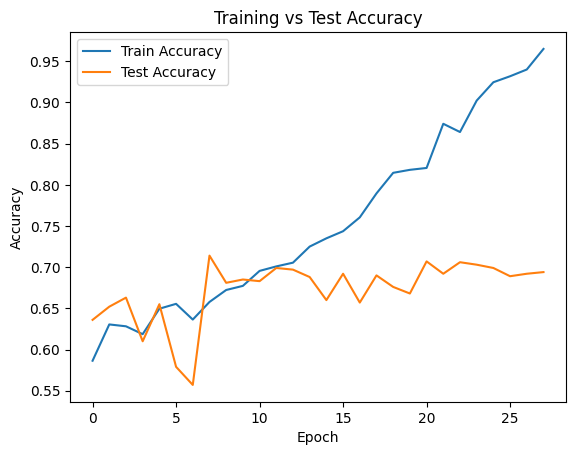

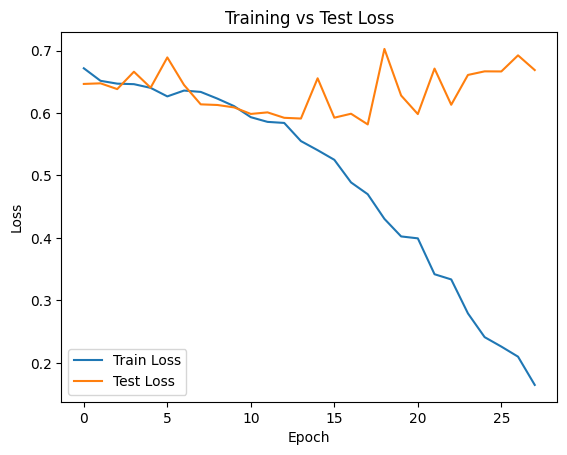

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Siamese Network class
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=10),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=7),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 128, kernel_size=4),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=4),
            nn.ReLU(),
        )
        dummy_input = torch.randn(1, 1, 125, 94)
        cnn_output = self.cnn(dummy_input)
        flattened_size = cnn_output.view(-1).size(0)

        self.fc = nn.Sequential(
            nn.Linear(flattened_size, 4096),
            nn.Sigmoid()
        )
        self.out = nn.Linear(4096, 1)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, mean=0.0, std=1e-2)
                if m.bias is not None:
                    nn.init.normal_(m.bias, mean=0.5, std=1e-2)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.2)
                if m.bias is not None:
                    nn.init.normal_(m.bias, mean=0.5, std=1e-2)

    def forward_one(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def forward(self, x1, x2):
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)
        dis = torch.abs(out1 - out2)
        out = self.out(dis)  # raw logits for BCEWithLogitsLoss
        return out.squeeze()  # No sigmoid here


class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                          label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss

def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    correct_pairs = 0
    wrong_pairs = 0
    total_loss = 0
    total_samples = 0

    with torch.no_grad():
        for img1, img2, label in data_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device).float()
            output = model(img1, img2)  # Single scalar output per pair
            loss = criterion(output, label)  # No need to squeeze; already scalar
            total_loss += loss.item() * label.size(0)

            # Apply sigmoid to get probabilities
            predictions = (torch.sigmoid(output) > 0.5).float()

            # Count correct and wrong pairs
            correct_pairs += (predictions == label).sum().item()
            wrong_pairs += (predictions != label).sum().item()
            total_samples += label.size(0)

    avg_loss = total_loss / total_samples
    return correct_pairs, wrong_pairs, avg_loss


def train_and_evaluate_with_schedule(
    model, train_loader, test_loader, criterion, optimizer, num_epochs=100, patience=20):

    best_wrong_pairs = float('inf')
    no_improve_epochs = 0
    history = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': [], 'wrong_pairs': []}

    for epoch in range(num_epochs):
        model.train()
        train_loss, correct_train = 0, 0

        for img1, img2, label in train_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device).float()

            optimizer.zero_grad()
            output = model(img1, img2)
            loss = criterion(output.view(-1), label)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * label.size(0)
            predictions = (torch.sigmoid(output) > 0.5).float()
            correct_train += (predictions == label).sum().item()

        train_loss /= len(train_loader.dataset)
        train_acc = correct_train / len(train_loader.dataset)

        print(f"Epoch {epoch+1}/{num_epochs}")
        test_correct, test_wrong, test_avg_loss = evaluate_model(model, test_loader, criterion, device)
        test_loss = test_avg_loss
        test_acc = test_correct / len(test_loader.dataset)

        print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
        print(f"Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, Wrong Pairs on test = {test_wrong}\\{test_correct + test_wrong}")

        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
        history['wrong_pairs'].append(test_wrong)

        if test_wrong < best_wrong_pairs:
            best_wrong_pairs = test_wrong
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1

        if no_improve_epochs >= patience:
            print("Early stopping triggered due to no improvement in wrong pairs.")
            break

    return history


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Instantiate model and move to device
model = SiameseNetwork().to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCEWithLogitsLoss()

# Train the model
history = train_and_evaluate_with_schedule(
    model, train_loader, test_loader, criterion, optimizer,
    num_epochs=300, patience=20)

# Plot results
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['test_acc'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Test Accuracy')
plt.show()

plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['test_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Test Loss')
plt.show()

Adding weight loss

Using device: cuda
Epoch 1/300
Train Loss: 0.6748, Test Loss: 0.6593
Train Acc: 0.5800, Test Acc: 0.6270, Wrong Pairs on test = 373\1000
Epoch 2/300
Train Loss: 0.6558, Test Loss: 0.6350
Train Acc: 0.6209, Test Acc: 0.6700, Wrong Pairs on test = 330\1000
Epoch 3/300
Train Loss: 0.6397, Test Loss: 0.6314
Train Acc: 0.6400, Test Acc: 0.6370, Wrong Pairs on test = 363\1000
Epoch 4/300
Train Loss: 0.6327, Test Loss: 0.6092
Train Acc: 0.6423, Test Acc: 0.6930, Wrong Pairs on test = 307\1000
Epoch 5/300
Train Loss: 0.6282, Test Loss: 0.6296
Train Acc: 0.6495, Test Acc: 0.6620, Wrong Pairs on test = 338\1000
Epoch 6/300
Train Loss: 0.6308, Test Loss: 0.6028
Train Acc: 0.6568, Test Acc: 0.6930, Wrong Pairs on test = 307\1000
Epoch 7/300
Train Loss: 0.6140, Test Loss: 0.6236
Train Acc: 0.6723, Test Acc: 0.6320, Wrong Pairs on test = 368\1000
Epoch 8/300
Train Loss: 0.6235, Test Loss: 0.6093
Train Acc: 0.6609, Test Acc: 0.6970, Wrong Pairs on test = 303\1000
Epoch 9/300
Train Loss: 0.6054, Test 

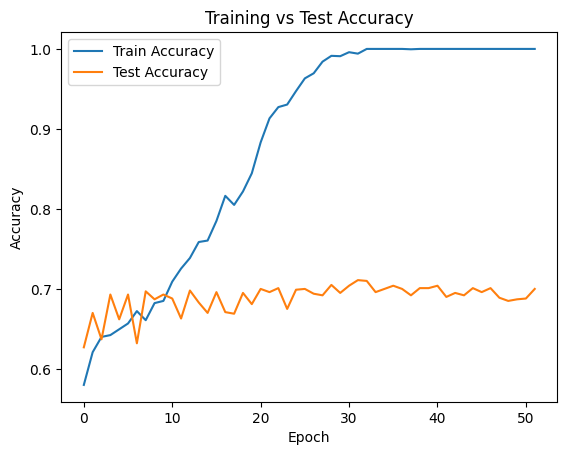

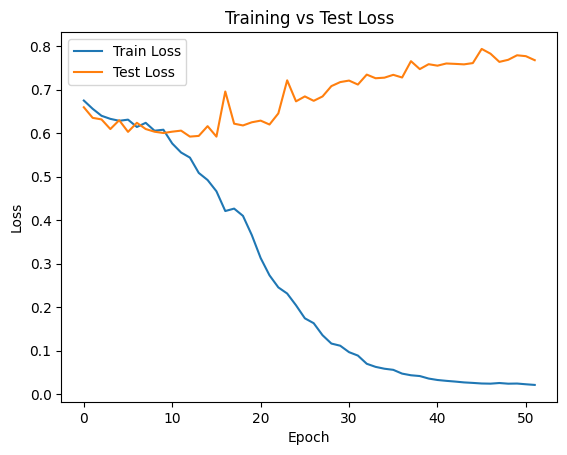

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Siamese Network class
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=10),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=7),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 128, kernel_size=4),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=4),
            nn.ReLU(),
        )
        dummy_input = torch.randn(1, 1, 125, 94)
        cnn_output = self.cnn(dummy_input)
        flattened_size = cnn_output.view(-1).size(0)

        self.fc = nn.Sequential(
            nn.Linear(flattened_size, 4096),
            nn.Sigmoid()
        )
        self.out = nn.Linear(4096, 1)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, mean=0.0, std=1e-2)
                if m.bias is not None:
                    nn.init.normal_(m.bias, mean=0.5, std=1e-2)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.2)
                if m.bias is not None:
                    nn.init.normal_(m.bias, mean=0.5, std=1e-2)

    def forward_one(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def forward(self, x1, x2):
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)
        dis = torch.abs(out1 - out2)
        out = self.out(dis)  # raw logits for BCEWithLogitsLoss
        return out.squeeze()  # No sigmoid here


class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                          label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss

def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    correct_pairs = 0
    wrong_pairs = 0
    total_loss = 0
    total_samples = 0

    with torch.no_grad():
        for img1, img2, label in data_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device).float()
            output = model(img1, img2)  # Single scalar output per pair
            loss = criterion(output, label)  # No need to squeeze; already scalar
            total_loss += loss.item() * label.size(0)

            # Apply sigmoid to get probabilities
            predictions = (torch.sigmoid(output) > 0.5).float()

            # Count correct and wrong pairs
            correct_pairs += (predictions == label).sum().item()
            wrong_pairs += (predictions != label).sum().item()
            total_samples += label.size(0)

    avg_loss = total_loss / total_samples
    return correct_pairs, wrong_pairs, avg_loss


def train_and_evaluate_with_schedule(
    model, train_loader, test_loader, criterion, optimizer, num_epochs=100, patience=20):

    best_wrong_pairs = float('inf')
    no_improve_epochs = 0
    history = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': [], 'wrong_pairs': []}

    for epoch in range(num_epochs):
        model.train()
        train_loss, correct_train = 0, 0

        for img1, img2, label in train_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device).float()

            optimizer.zero_grad()
            output = model(img1, img2)
            loss = criterion(output.view(-1), label)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * label.size(0)
            predictions = (torch.sigmoid(output) > 0.5).float()
            correct_train += (predictions == label).sum().item()

        train_loss /= len(train_loader.dataset)
        train_acc = correct_train / len(train_loader.dataset)

        print(f"Epoch {epoch+1}/{num_epochs}")
        test_correct, test_wrong, test_avg_loss = evaluate_model(model, test_loader, criterion, device)
        test_loss = test_avg_loss
        test_acc = test_correct / len(test_loader.dataset)

        print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
        print(f"Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, Wrong Pairs on test = {test_wrong}\\{test_correct + test_wrong}")

        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
        history['wrong_pairs'].append(test_wrong)

        if test_wrong < best_wrong_pairs:
            best_wrong_pairs = test_wrong
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1

        if no_improve_epochs >= patience:
            print("Early stopping triggered due to no improvement in wrong pairs.")
            break

    return history


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Instantiate model and move to device
model = SiameseNetwork().to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)
criterion = nn.BCEWithLogitsLoss()

# Train the model
history = train_and_evaluate_with_schedule(
    model, train_loader, test_loader, criterion, optimizer,
    num_epochs=300, patience=20)

# Plot results
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['test_acc'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Test Accuracy')
plt.show()

plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['test_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Test Loss')
plt.show()

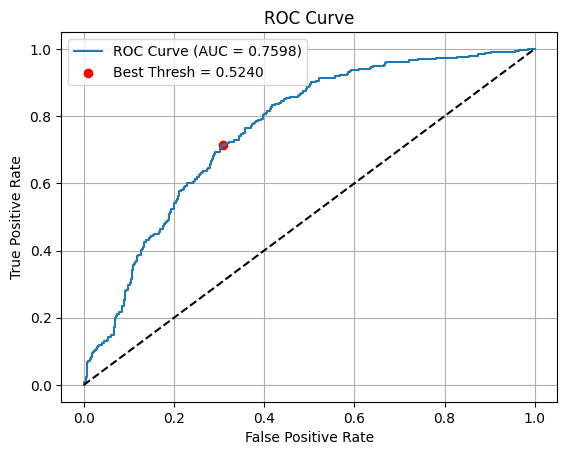

Best Threshold: 0.5240


In [10]:
best_threshold = find_best_threshold_and_plot_roc(model, test_loader, device)


Using optuna to optimize it

In [ ]:
# %pip install optuna


In [20]:
import optuna
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Siamese Network class
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=10),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=7),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 128, kernel_size=4),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=4),
            nn.ReLU(),
        )
        dummy_input = torch.randn(1, 1, 125, 94)
        cnn_output = self.cnn(dummy_input)
        flattened_size = cnn_output.view(-1).size(0)

        self.fc = nn.Sequential(
            nn.Linear(flattened_size, 4096),
            nn.Sigmoid()
        )
        self.out = nn.Linear(4096, 1)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, mean=0.0, std=1e-2)
                if m.bias is not None:
                    nn.init.normal_(m.bias, mean=0.5, std=1e-2)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.2)
                if m.bias is not None:
                    nn.init.normal_(m.bias, mean=0.5, std=1e-2)

    def forward_one(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def forward(self, x1, x2):
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)
        dis = torch.abs(out1 - out2)
        out = self.out(dis)  # raw logits for BCEWithLogitsLoss
        return out.squeeze()  # No sigmoid here


class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                          label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss

def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    correct_pairs = 0
    wrong_pairs = 0
    total_loss = 0
    total_samples = 0

    with torch.no_grad():
        for img1, img2, label in data_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device).float()
            output = model(img1, img2)  # Single scalar output per pair
            loss = criterion(output, label)  # No need to squeeze; already scalar
            total_loss += loss.item() * label.size(0)

            # Apply sigmoid to get probabilities
            predictions = (torch.sigmoid(output) > 0.5).float()

            # Count correct and wrong pairs
            correct_pairs += (predictions == label).sum().item()
            wrong_pairs += (predictions != label).sum().item()
            total_samples += label.size(0)

    avg_loss = total_loss / total_samples
    return correct_pairs, wrong_pairs, avg_loss


def train_and_evaluate_with_schedule(
    model, train_loader, test_loader, criterion, optimizer, num_epochs=100, patience=20):

    best_wrong_pairs = float('inf')
    no_improve_epochs = 0
    history = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': [], 'wrong_pairs': []}

    for epoch in range(num_epochs):
        model.train()
        train_loss, correct_train = 0, 0

        for img1, img2, label in train_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device).float()

            optimizer.zero_grad()
            output = model(img1, img2)
            loss = criterion(output.view(-1), label)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * label.size(0)
            predictions = (torch.sigmoid(output) > 0.5).float()
            correct_train += (predictions == label).sum().item()

        train_loss /= len(train_loader.dataset)
        train_acc = correct_train / len(train_loader.dataset)

        print(f"Epoch {epoch+1}/{num_epochs}")
        test_correct, test_wrong, test_avg_loss = evaluate_model(model, test_loader, criterion, device)
        test_loss = test_avg_loss
        test_acc = test_correct / len(test_loader.dataset)

        print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
        print(f"Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, Wrong Pairs on test = {test_wrong}\\{test_correct + test_wrong}")

        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
        history['wrong_pairs'].append(test_wrong)

        if test_wrong < best_wrong_pairs:
            best_wrong_pairs = test_wrong
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1

        if no_improve_epochs >= patience:
            print("Early stopping triggered due to no improvement in wrong pairs.")
            break

    return history

def objective(trial):
    # Suggest hyperparameters
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-1)

    # Create model and optimizer
    model = SiameseNetwork().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.BCEWithLogitsLoss()

    # Train and evaluate
    history = train_and_evaluate_with_schedule(
        model, train_loader, test_loader, criterion, optimizer,
        num_epochs=50, patience=10
    )

    # Return the test error (minimize wrong pairs)
    return min(history['wrong_pairs']) 


study = optuna.create_study(direction='minimize')  # minimize wrong pairs or loss
study.optimize(objective, n_trials=10)  # You can increase trials for better results

print("Best hyperparameters:", study.best_params)
print("Best wrong pairs:", study.best_value)
print("Best trial:", study.best_trial)




[I 2025-04-30 13:46:32,971] A new study created in memory with name: no-name-6408b925-440a-4433-99af-a1a4fa36ad1a
C:\Users\iftac\AppData\Local\Temp\ipykernel_2216\2886343064.py:150: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
C:\Users\iftac\AppData\Local\Temp\ipykernel_2216\2886343064.py:151: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-1)


Epoch 1/50
Train Loss: 0.7688, Test Loss: 0.7515
Train Acc: 0.5155, Test Acc: 0.5190, Wrong Pairs on test = 481\1000
Epoch 2/50
Train Loss: 0.8862, Test Loss: 0.7124
Train Acc: 0.5059, Test Acc: 0.5200, Wrong Pairs on test = 480\1000
Epoch 3/50
Train Loss: 0.7409, Test Loss: 0.7980
Train Acc: 0.5050, Test Acc: 0.5040, Wrong Pairs on test = 496\1000
Epoch 4/50
Train Loss: 0.7373, Test Loss: 0.7044
Train Acc: 0.5068, Test Acc: 0.5370, Wrong Pairs on test = 463\1000
Epoch 5/50
Train Loss: 0.7038, Test Loss: 0.6959
Train Acc: 0.5027, Test Acc: 0.5440, Wrong Pairs on test = 456\1000
Epoch 6/50
Train Loss: 0.7084, Test Loss: 0.7282
Train Acc: 0.5018, Test Acc: 0.5000, Wrong Pairs on test = 500\1000
Epoch 7/50
Train Loss: 0.7029, Test Loss: 0.6962
Train Acc: 0.4995, Test Acc: 0.5080, Wrong Pairs on test = 492\1000
Epoch 8/50
Train Loss: 0.6986, Test Loss: 0.6939
Train Acc: 0.4991, Test Acc: 0.5080, Wrong Pairs on test = 492\1000
Epoch 9/50
Train Loss: 0.6959, Test Loss: 0.6938
Train Acc: 0.50

[I 2025-04-30 13:47:20,836] Trial 0 finished with value: 456.0 and parameters: {'lr': 0.005203899784359106, 'weight_decay': 8.633743057975772e-05}. Best is trial 0 with value: 456.0.


Train Loss: 0.6942, Test Loss: 0.6929
Train Acc: 0.4995, Test Acc: 0.5180, Wrong Pairs on test = 482\1000
Early stopping triggered due to no improvement in wrong pairs.
Epoch 1/50
Train Loss: 0.7164, Test Loss: 0.7388
Train Acc: 0.5314, Test Acc: 0.5240, Wrong Pairs on test = 476\1000
Epoch 2/50
Train Loss: 0.7397, Test Loss: 0.6989
Train Acc: 0.5200, Test Acc: 0.5500, Wrong Pairs on test = 450\1000
Epoch 3/50
Train Loss: 0.7337, Test Loss: 0.7446
Train Acc: 0.5373, Test Acc: 0.5760, Wrong Pairs on test = 424\1000
Epoch 4/50
Train Loss: 0.7955, Test Loss: 0.8564
Train Acc: 0.5127, Test Acc: 0.5090, Wrong Pairs on test = 491\1000
Epoch 5/50
Train Loss: 0.8245, Test Loss: 0.7534
Train Acc: 0.5236, Test Acc: 0.5280, Wrong Pairs on test = 472\1000
Epoch 6/50
Train Loss: 0.7788, Test Loss: 0.7966
Train Acc: 0.5314, Test Acc: 0.5250, Wrong Pairs on test = 475\1000
Epoch 7/50
Train Loss: 0.7381, Test Loss: 0.6998
Train Acc: 0.5523, Test Acc: 0.5690, Wrong Pairs on test = 431\1000
Epoch 8/50
T

[I 2025-04-30 13:48:02,190] Trial 1 finished with value: 424.0 and parameters: {'lr': 0.0022811342361044222, 'weight_decay': 2.0227107231263605e-06}. Best is trial 1 with value: 424.0.


Train Loss: 0.6920, Test Loss: 0.6972
Train Acc: 0.5345, Test Acc: 0.5100, Wrong Pairs on test = 490\1000
Early stopping triggered due to no improvement in wrong pairs.
Epoch 1/50
Train Loss: 0.6935, Test Loss: 0.7116
Train Acc: 0.5409, Test Acc: 0.5000, Wrong Pairs on test = 500\1000
Epoch 2/50
Train Loss: 0.6886, Test Loss: 0.6735
Train Acc: 0.5468, Test Acc: 0.6010, Wrong Pairs on test = 399\1000
Epoch 3/50
Train Loss: 0.6827, Test Loss: 0.6761
Train Acc: 0.5664, Test Acc: 0.5890, Wrong Pairs on test = 411\1000
Epoch 4/50
Train Loss: 0.6764, Test Loss: 0.6772
Train Acc: 0.5845, Test Acc: 0.5710, Wrong Pairs on test = 429\1000
Epoch 5/50
Train Loss: 0.6712, Test Loss: 0.6867
Train Acc: 0.5855, Test Acc: 0.5240, Wrong Pairs on test = 476\1000
Epoch 6/50
Train Loss: 0.6673, Test Loss: 0.6405
Train Acc: 0.5945, Test Acc: 0.6510, Wrong Pairs on test = 349\1000
Epoch 7/50
Train Loss: 0.6519, Test Loss: 0.7540
Train Acc: 0.6273, Test Acc: 0.5110, Wrong Pairs on test = 489\1000
Epoch 8/50
T

[I 2025-04-30 13:49:15,583] Trial 2 finished with value: 303.0 and parameters: {'lr': 0.00030980841038206515, 'weight_decay': 0.010770502252621305}. Best is trial 2 with value: 303.0.


Train Loss: 0.5199, Test Loss: 0.5976
Train Acc: 0.7518, Test Acc: 0.6740, Wrong Pairs on test = 326\1000
Early stopping triggered due to no improvement in wrong pairs.
Epoch 1/50
Train Loss: 0.7879, Test Loss: 0.7571
Train Acc: 0.5064, Test Acc: 0.5460, Wrong Pairs on test = 454\1000
Epoch 2/50
Train Loss: 0.7319, Test Loss: 0.7080
Train Acc: 0.5391, Test Acc: 0.5520, Wrong Pairs on test = 448\1000
Epoch 3/50
Train Loss: 0.7477, Test Loss: 0.7251
Train Acc: 0.5150, Test Acc: 0.5100, Wrong Pairs on test = 490\1000
Epoch 4/50
Train Loss: 0.7223, Test Loss: 0.6923
Train Acc: 0.5277, Test Acc: 0.5280, Wrong Pairs on test = 472\1000
Epoch 5/50
Train Loss: 0.7013, Test Loss: 0.7340
Train Acc: 0.5382, Test Acc: 0.5050, Wrong Pairs on test = 495\1000
Epoch 6/50
Train Loss: 0.7081, Test Loss: 0.6947
Train Acc: 0.5236, Test Acc: 0.5200, Wrong Pairs on test = 480\1000
Epoch 7/50
Train Loss: 0.6946, Test Loss: 0.7010
Train Acc: 0.5159, Test Acc: 0.5120, Wrong Pairs on test = 488\1000
Epoch 8/50
T

[I 2025-04-30 13:49:54,034] Trial 3 finished with value: 448.0 and parameters: {'lr': 0.0060437090289026775, 'weight_decay': 0.00016931162474928546}. Best is trial 2 with value: 303.0.


Train Loss: 0.6937, Test Loss: 0.6947
Train Acc: 0.5055, Test Acc: 0.4950, Wrong Pairs on test = 505\1000
Early stopping triggered due to no improvement in wrong pairs.
Epoch 1/50
Train Loss: 0.6729, Test Loss: 0.6564
Train Acc: 0.5914, Test Acc: 0.6470, Wrong Pairs on test = 353\1000
Epoch 2/50
Train Loss: 0.6548, Test Loss: 0.6400
Train Acc: 0.6286, Test Acc: 0.6390, Wrong Pairs on test = 361\1000
Epoch 3/50
Train Loss: 0.6446, Test Loss: 0.6378
Train Acc: 0.6382, Test Acc: 0.6660, Wrong Pairs on test = 334\1000
Epoch 4/50
Train Loss: 0.6332, Test Loss: 0.6251
Train Acc: 0.6491, Test Acc: 0.6610, Wrong Pairs on test = 339\1000
Epoch 5/50
Train Loss: 0.6222, Test Loss: 0.6168
Train Acc: 0.6555, Test Acc: 0.6820, Wrong Pairs on test = 318\1000
Epoch 6/50
Train Loss: 0.6187, Test Loss: 0.6101
Train Acc: 0.6627, Test Acc: 0.6740, Wrong Pairs on test = 326\1000
Epoch 7/50
Train Loss: 0.6148, Test Loss: 0.6122
Train Acc: 0.6782, Test Acc: 0.6860, Wrong Pairs on test = 314\1000
Epoch 8/50
T

[I 2025-04-30 13:51:46,090] Trial 4 finished with value: 284.0 and parameters: {'lr': 2.479293849241122e-05, 'weight_decay': 0.02017131941721848}. Best is trial 4 with value: 284.0.


Train Loss: 0.2378, Test Loss: 0.6727
Train Acc: 0.9332, Test Acc: 0.6800, Wrong Pairs on test = 320\1000
Early stopping triggered due to no improvement in wrong pairs.
Epoch 1/50
Train Loss: 0.6714, Test Loss: 0.6667
Train Acc: 0.5955, Test Acc: 0.6070, Wrong Pairs on test = 393\1000
Epoch 2/50
Train Loss: 0.6537, Test Loss: 0.6316
Train Acc: 0.6286, Test Acc: 0.6640, Wrong Pairs on test = 336\1000
Epoch 3/50
Train Loss: 0.6353, Test Loss: 0.6176
Train Acc: 0.6505, Test Acc: 0.6700, Wrong Pairs on test = 330\1000
Epoch 4/50
Train Loss: 0.6264, Test Loss: 0.6262
Train Acc: 0.6764, Test Acc: 0.6410, Wrong Pairs on test = 359\1000
Epoch 5/50
Train Loss: 0.6251, Test Loss: 0.6155
Train Acc: 0.6686, Test Acc: 0.6720, Wrong Pairs on test = 328\1000
Epoch 6/50
Train Loss: 0.6115, Test Loss: 0.6322
Train Acc: 0.6895, Test Acc: 0.6460, Wrong Pairs on test = 354\1000
Epoch 7/50
Train Loss: 0.6037, Test Loss: 0.6041
Train Acc: 0.6732, Test Acc: 0.6800, Wrong Pairs on test = 320\1000
Epoch 8/50
T

[I 2025-04-30 13:52:47,009] Trial 5 finished with value: 307.0 and parameters: {'lr': 3.455746819670957e-05, 'weight_decay': 7.088723788105231e-05}. Best is trial 4 with value: 284.0.


Train Loss: 0.4149, Test Loss: 0.6416
Train Acc: 0.8214, Test Acc: 0.6850, Wrong Pairs on test = 315\1000
Early stopping triggered due to no improvement in wrong pairs.
Epoch 1/50
Train Loss: 0.7985, Test Loss: 0.7166
Train Acc: 0.5114, Test Acc: 0.5490, Wrong Pairs on test = 451\1000
Epoch 2/50
Train Loss: 0.7514, Test Loss: 0.8229
Train Acc: 0.5186, Test Acc: 0.4950, Wrong Pairs on test = 505\1000
Epoch 3/50
Train Loss: 0.7347, Test Loss: 0.7033
Train Acc: 0.5227, Test Acc: 0.5420, Wrong Pairs on test = 458\1000
Epoch 4/50
Train Loss: 0.7102, Test Loss: 0.6884
Train Acc: 0.5291, Test Acc: 0.5810, Wrong Pairs on test = 419\1000
Epoch 5/50
Train Loss: 0.6876, Test Loss: 0.6977
Train Acc: 0.5486, Test Acc: 0.5310, Wrong Pairs on test = 469\1000
Epoch 6/50
Train Loss: 0.7013, Test Loss: 0.6851
Train Acc: 0.5223, Test Acc: 0.5650, Wrong Pairs on test = 435\1000
Epoch 7/50
Train Loss: 0.7021, Test Loss: 0.7042
Train Acc: 0.5145, Test Acc: 0.5480, Wrong Pairs on test = 452\1000
Epoch 8/50
T

[I 2025-04-30 13:53:32,012] Trial 6 finished with value: 419.0 and parameters: {'lr': 0.005236852540471747, 'weight_decay': 0.0003877186594912335}. Best is trial 4 with value: 284.0.


Train Loss: 0.6930, Test Loss: 0.6922
Train Acc: 0.5141, Test Acc: 0.5470, Wrong Pairs on test = 453\1000
Early stopping triggered due to no improvement in wrong pairs.
Epoch 1/50
Train Loss: 0.7630, Test Loss: 0.7296
Train Acc: 0.5214, Test Acc: 0.5350, Wrong Pairs on test = 465\1000
Epoch 2/50
Train Loss: 0.7220, Test Loss: 0.7459
Train Acc: 0.5223, Test Acc: 0.5060, Wrong Pairs on test = 494\1000
Epoch 3/50
Train Loss: 0.7268, Test Loss: 0.7326
Train Acc: 0.5073, Test Acc: 0.5130, Wrong Pairs on test = 487\1000
Epoch 4/50
Train Loss: 0.7167, Test Loss: 0.6889
Train Acc: 0.5345, Test Acc: 0.5600, Wrong Pairs on test = 440\1000
Epoch 5/50
Train Loss: 0.7237, Test Loss: 0.7227
Train Acc: 0.5209, Test Acc: 0.4990, Wrong Pairs on test = 501\1000
Epoch 6/50
Train Loss: 0.7096, Test Loss: 0.7154
Train Acc: 0.5059, Test Acc: 0.5000, Wrong Pairs on test = 500\1000
Epoch 7/50
Train Loss: 0.7070, Test Loss: 0.6818
Train Acc: 0.4995, Test Acc: 0.5540, Wrong Pairs on test = 446\1000
Epoch 8/50
T

[I 2025-04-30 13:54:16,792] Trial 7 finished with value: 440.0 and parameters: {'lr': 0.005509773421290128, 'weight_decay': 6.691085260467523e-06}. Best is trial 4 with value: 284.0.


Train Loss: 0.6939, Test Loss: 0.6954
Train Acc: 0.5045, Test Acc: 0.5060, Wrong Pairs on test = 494\1000
Early stopping triggered due to no improvement in wrong pairs.
Epoch 1/50
Train Loss: 0.6854, Test Loss: 0.6880
Train Acc: 0.5605, Test Acc: 0.5180, Wrong Pairs on test = 482\1000
Epoch 2/50
Train Loss: 0.6862, Test Loss: 0.6799
Train Acc: 0.5550, Test Acc: 0.5570, Wrong Pairs on test = 443\1000
Epoch 3/50
Train Loss: 0.6810, Test Loss: 0.6921
Train Acc: 0.5673, Test Acc: 0.5350, Wrong Pairs on test = 465\1000
Epoch 4/50
Train Loss: 0.6923, Test Loss: 0.7003
Train Acc: 0.5650, Test Acc: 0.5000, Wrong Pairs on test = 500\1000
Epoch 5/50
Train Loss: 0.6937, Test Loss: 0.6758
Train Acc: 0.5327, Test Acc: 0.5650, Wrong Pairs on test = 435\1000
Epoch 6/50
Train Loss: 0.6916, Test Loss: 0.6833
Train Acc: 0.5318, Test Acc: 0.5630, Wrong Pairs on test = 437\1000
Epoch 7/50
Train Loss: 0.6786, Test Loss: 0.7130
Train Acc: 0.5800, Test Acc: 0.5210, Wrong Pairs on test = 479\1000
Epoch 8/50
T

[I 2025-04-30 13:55:49,725] Trial 8 finished with value: 338.0 and parameters: {'lr': 0.0002889734781347871, 'weight_decay': 0.00010894551955738263}. Best is trial 4 with value: 284.0.


Train Loss: 0.6356, Test Loss: 0.6424
Train Acc: 0.6477, Test Acc: 0.6420, Wrong Pairs on test = 358\1000
Early stopping triggered due to no improvement in wrong pairs.
Epoch 1/50
Train Loss: 0.8620, Test Loss: 0.7443
Train Acc: 0.5191, Test Acc: 0.4980, Wrong Pairs on test = 502\1000
Epoch 2/50
Train Loss: 0.7360, Test Loss: 0.7725
Train Acc: 0.5036, Test Acc: 0.5040, Wrong Pairs on test = 496\1000
Epoch 3/50
Train Loss: 0.7211, Test Loss: 0.7334
Train Acc: 0.5091, Test Acc: 0.4980, Wrong Pairs on test = 502\1000
Epoch 4/50
Train Loss: 0.7144, Test Loss: 0.7216
Train Acc: 0.5014, Test Acc: 0.5000, Wrong Pairs on test = 500\1000
Epoch 5/50
Train Loss: 0.7057, Test Loss: 0.7068
Train Acc: 0.5014, Test Acc: 0.4990, Wrong Pairs on test = 501\1000
Epoch 6/50
Train Loss: 0.7055, Test Loss: 0.7077
Train Acc: 0.5068, Test Acc: 0.5000, Wrong Pairs on test = 500\1000
Epoch 7/50
Train Loss: 0.6999, Test Loss: 0.6755
Train Acc: 0.5182, Test Acc: 0.5740, Wrong Pairs on test = 426\1000
Epoch 8/50
T

[I 2025-04-30 13:57:25,802] Trial 9 finished with value: 360.0 and parameters: {'lr': 0.002110943005548524, 'weight_decay': 0.05722282175892318}. Best is trial 4 with value: 284.0.


Train Loss: 0.6700, Test Loss: 0.6575
Train Acc: 0.5964, Test Acc: 0.6300, Wrong Pairs on test = 370\1000
Early stopping triggered due to no improvement in wrong pairs.
Best hyperparameters: {'lr': 2.479293849241122e-05, 'weight_decay': 0.02017131941721848}
Best wrong pairs: 284.0
Best trial: FrozenTrial(number=4, state=1, values=[284.0], datetime_start=datetime.datetime(2025, 4, 30, 13, 49, 54, 35505), datetime_complete=datetime.datetime(2025, 4, 30, 13, 51, 46, 90676), params={'lr': 2.479293849241122e-05, 'weight_decay': 0.02017131941721848}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lr': FloatDistribution(high=0.01, log=True, low=1e-05, step=None), 'weight_decay': FloatDistribution(high=0.1, log=True, low=1e-06, step=None)}, trial_id=4, value=None)


Trying to do batch normalization:

Using device: cuda
Epoch 1/300
Train Loss: 1.9163, Test Loss: 1.0787
Train Acc: 0.5355, Test Acc: 0.5180, Wrong Pairs on test = 482\1000
Epoch 2/300
Train Loss: 0.9842, Test Loss: 1.6760
Train Acc: 0.7082, Test Acc: 0.5540, Wrong Pairs on test = 446\1000
Epoch 3/300
Train Loss: 0.5129, Test Loss: 1.6858
Train Acc: 0.8255, Test Acc: 0.5780, Wrong Pairs on test = 422\1000
Epoch 4/300
Train Loss: 0.2897, Test Loss: 1.7345
Train Acc: 0.8955, Test Acc: 0.5820, Wrong Pairs on test = 418\1000
Epoch 5/300
Train Loss: 0.1705, Test Loss: 1.6419
Train Acc: 0.9359, Test Acc: 0.5800, Wrong Pairs on test = 420\1000
Epoch 6/300
Train Loss: 0.1174, Test Loss: 1.5996
Train Acc: 0.9518, Test Acc: 0.5930, Wrong Pairs on test = 407\1000
Epoch 7/300
Train Loss: 0.1143, Test Loss: 1.5803
Train Acc: 0.9568, Test Acc: 0.6010, Wrong Pairs on test = 399\1000
Epoch 8/300
Train Loss: 0.1362, Test Loss: 1.5329
Train Acc: 0.9436, Test Acc: 0.6080, Wrong Pairs on test = 392\1000
Epoch 9/300
Train Loss: 0.1098, Test 

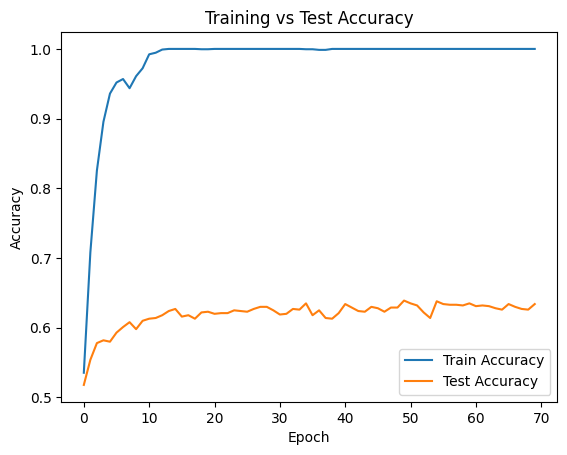

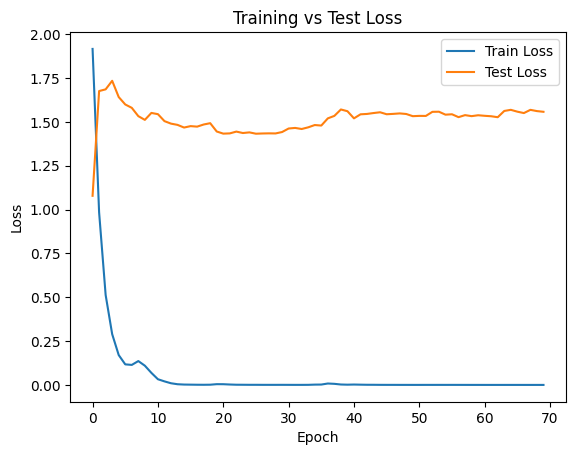

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Siamese Network class
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=10),
            nn.BatchNorm2d(64),  # Batch normalization
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=7),
            nn.BatchNorm2d(128),  # Batch normalization
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 128, kernel_size=4),
            nn.BatchNorm2d(128),  # Batch normalization
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=4),
            nn.BatchNorm2d(256),  # Batch normalization
            nn.ReLU()
        )
        dummy_input = torch.randn(1, 1, 125, 94)
        cnn_output = self.cnn(dummy_input)
        flattened_size = cnn_output.view(-1).size(0)

        self.fc = nn.Sequential(
            nn.Linear(flattened_size, 4096),
            nn.Sigmoid()
        )
        self.out = nn.Linear(4096, 1)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, mean=0.0, std=1e-2)
                if m.bias is not None:
                    nn.init.normal_(m.bias, mean=0.5, std=1e-2)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.2)
                if m.bias is not None:
                    nn.init.normal_(m.bias, mean=0.5, std=1e-2)

    def forward_one(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def forward(self, x1, x2):
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)
        dis = torch.abs(out1 - out2)
        out = self.out(dis)  # raw logits for BCEWithLogitsLoss
        return out.squeeze()  # No sigmoid here



# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Instantiate model and move to device
model = SiameseNetwork().to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for binary classification

# Train the model
history = train_and_evaluate_with_schedule(
    model, train_loader, test_loader, criterion, optimizer,
    num_epochs=300, patience=20)

# Plot results
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['test_acc'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Test Accuracy')
plt.show()

plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['test_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Test Loss')
plt.show()


In [21]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop((125, 94), scale=(0.8, 1.0)),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((125, 94)),
    transforms.ToTensor()
])


Warning!!!! after runnig this, make sure you run the test \ train loaders again, since it's changed to support augmentations.

Here I tried to do augmentations

Using device: cuda
Epoch 1/300
Train Loss: 0.6761, Test Loss: 0.6521
Train Acc: 0.5641, Test Acc: 0.6290, Wrong Pairs on test = 371\1000
Epoch 2/300
Train Loss: 0.6702, Test Loss: 0.6596
Train Acc: 0.5900, Test Acc: 0.6360, Wrong Pairs on test = 364\1000
Epoch 3/300
Train Loss: 0.6696, Test Loss: 0.6698
Train Acc: 0.5850, Test Acc: 0.5440, Wrong Pairs on test = 456\1000
Epoch 4/300
Train Loss: 0.6668, Test Loss: 0.6471
Train Acc: 0.6000, Test Acc: 0.6120, Wrong Pairs on test = 388\1000
Epoch 5/300
Train Loss: 0.6603, Test Loss: 0.6712
Train Acc: 0.6059, Test Acc: 0.5470, Wrong Pairs on test = 453\1000
Epoch 6/300
Train Loss: 0.6792, Test Loss: 0.6677
Train Acc: 0.5627, Test Acc: 0.5840, Wrong Pairs on test = 416\1000
Epoch 7/300
Train Loss: 0.6630, Test Loss: 0.6407
Train Acc: 0.6218, Test Acc: 0.6500, Wrong Pairs on test = 350\1000
Epoch 8/300
Train Loss: 0.6589, Test Loss: 0.6355
Train Acc: 0.6091, Test Acc: 0.6560, Wrong Pairs on test = 344\1000
Epoch 9/300
Train Loss: 0.6628, Test 

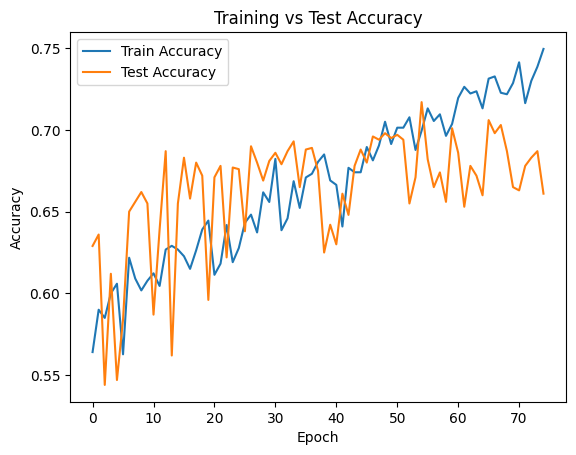

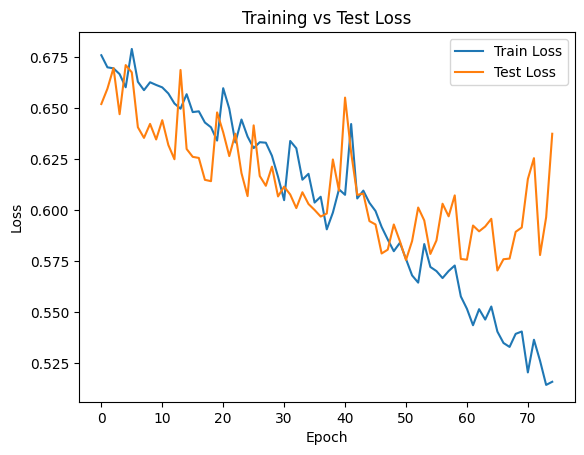

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


class SiameseDataset(Dataset):
    def __init__(self, pairs, labels, transform=None):
        self.pairs = pairs
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        img1, img2 = self.pairs[index]
        label = self.labels[index]

        # Apply transformations if provided
        if self.transform:
            img1 = self.transform(Image.fromarray(img1))
            img2 = self.transform(Image.fromarray(img2))
        else:
            img1 = torch.tensor(img1, dtype=torch.float32).reshape(1, 125, 94) / 255.0
            img2 = torch.tensor(img2, dtype=torch.float32).reshape(1, 125, 94) / 255.0

        label = torch.tensor(label, dtype=torch.float32)
        return img1, img2, label

    def __len__(self):
        return len(self.pairs)

# Siamese Network class
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=10),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=7),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 128, kernel_size=4),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=4),
            nn.ReLU()
        )
        dummy_input = torch.randn(1, 1, 125, 94)
        cnn_output = self.cnn(dummy_input)
        flattened_size = cnn_output.view(-1).size(0)

        self.fc = nn.Sequential(
            nn.Linear(flattened_size, 4096),
            nn.Sigmoid()
        )
        self.out = nn.Linear(4096, 1)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, mean=0.0, std=1e-2)
                if m.bias is not None:
                    nn.init.normal_(m.bias, mean=0.5, std=1e-2)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.2)
                if m.bias is not None:
                    nn.init.normal_(m.bias, mean=0.5, std=1e-2)

    def forward_one(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def forward(self, x1, x2):
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)
        dis = torch.abs(out1 - out2)
        out = self.out(dis)  # raw logits for BCEWithLogitsLoss
        return out.squeeze()  # No sigmoid here



# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Instantiate model and move to device
model = SiameseNetwork().to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)
criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for binary classification

# Create datasets with transformations
train_dataset = SiameseDataset(train_pairs, train_labels, transform=train_transforms)
test_dataset = SiameseDataset(test_pairs, test_labels, transform=test_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Train the model
history = train_and_evaluate_with_schedule(
    model, train_loader, test_loader, criterion, optimizer,
    num_epochs=300, patience=20)

# Plot results
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['test_acc'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Test Accuracy')
plt.show()

plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['test_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Test Loss')
plt.show()


# New method:
using the following paper: https://arxiv.org/pdf/2002.05709

In [ ]:
# # === Imports ===
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms
# from PIL import Image
# import matplotlib.pyplot as plt

# # === Define Transformations ===
# augmentation_transforms = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(10),
#     transforms.RandomResizedCrop((125, 94), scale=(0.8, 1.0)),
# ])

# basic_transform = transforms.ToTensor()

# # === Contrastive Loss ===
# class ContrastiveLoss(nn.Module):
#     def __init__(self, margin=1.0):
#         super(ContrastiveLoss, self).__init__()
#         self.margin = margin

#     def forward(self, output1, output2, label):
#         distances = nn.functional.pairwise_distance(output1, output2)
#         loss = (label) * torch.pow(distances, 2) + \
#                (1 - label) * torch.pow(torch.clamp(self.margin - distances, min=0.0), 2)
#         return loss.mean()

# # === Siamese Dataset ===
# class SiameseDatasetWithAugmentation(Dataset):
#     def __init__(self, pairs, labels, transform=None, augmentation=None, is_train=True):
#         self.pairs = pairs
#         self.labels = labels
#         self.transform = transform
#         self.augmentation = augmentation
#         self.is_train = is_train

#     def __getitem__(self, index):
#         img1, img2 = self.pairs[index]
#         label = self.labels[index]

#         if isinstance(img1, torch.Tensor):
#             img1 = transforms.ToPILImage()(img1)
#         else:
#             img1 = Image.fromarray(img1)

#         if isinstance(img2, torch.Tensor):
#             img2 = transforms.ToPILImage()(img2)
#         else:
#             img2 = Image.fromarray(img2)

#         if self.is_train and self.augmentation:
#             img1_aug = self.augmentation(img1)
#             img2_aug = self.augmentation(img2)
#         else:
#             img1_aug = img1
#             img2_aug = img2

#         if self.transform:
#             img1 = self.transform(img1)
#             img2 = self.transform(img2)
#             img1_aug = self.transform(img1_aug)
#             img2_aug = self.transform(img2_aug)

#         label = torch.tensor(label, dtype=torch.float32)

#         return img1, img2, img1_aug, img2_aug, label

#     def __len__(self):
#         return len(self.pairs)

# # === Siamese Network ===
# class SiameseNetwork(nn.Module):
#     def __init__(self):
#         super(SiameseNetwork, self).__init__()
#         self.cnn = nn.Sequential(
#             nn.Conv2d(1, 64, kernel_size=10),
#             nn.ReLU(),
#             nn.MaxPool2d(2),
#             nn.Conv2d(64, 128, kernel_size=7),
#             nn.ReLU(),
#             nn.MaxPool2d(2),
#             nn.Conv2d(128, 128, kernel_size=4),
#             nn.ReLU(),
#             nn.MaxPool2d(2),
#             nn.Conv2d(128, 256, kernel_size=4),
#             nn.ReLU(),
#         )

#         dummy_input = torch.randn(1, 1, 125, 94)
#         cnn_output = self.cnn(dummy_input)
#         flattened_size = cnn_output.view(-1).size(0)

#         self.fc = nn.Sequential(
#             nn.Linear(flattened_size, 4096),
#             nn.Sigmoid()
#         )

#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 nn.init.normal_(m.weight, mean=0.0, std=1e-2)
#                 if m.bias is not None:
#                     nn.init.normal_(m.bias, mean=0.5, std=1e-2)
#             elif isinstance(m, nn.Linear):
#                 nn.init.normal_(m.weight, mean=0.0, std=0.2)
#                 if m.bias is not None:
#                     nn.init.normal_(m.bias, mean=0.5, std=1e-2)

#     def forward_one(self, x):
#         x = self.cnn(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)
#         return x

#     def forward(self, x1, x2):
#         out1 = self.forward_one(x1)
#         out2 = self.forward_one(x2)
#         return out1, out2

# # === Evaluation Function ===
# def evaluate_accuracy(model, data_loader, device, threshold=0.5):
#     model.eval()
#     correct = 0
#     total = 0

#     with torch.no_grad():
#         for img1, img2, _, _, label in data_loader:
#             img1, img2, label = img1.to(device), img2.to(device), label.to(device)

#             output1, output2 = model(img1, img2)
#             distances = torch.nn.functional.pairwise_distance(output1, output2)

#             preds = (distances < threshold).float()
#             correct += (preds == label).sum().item()
#             total += label.size(0)

#     accuracy = correct / total
#     return accuracy

# # === Train Function with Accuracy Tracking ===
# def train_with_augmentation(
#     model, train_loader, test_loader, criterion, optimizer, device, num_epochs=50, threshold=0.5
# ):
#     history = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': []}

#     for epoch in range(num_epochs):
#         model.train()
#         total_loss = 0

#         for img1, img2, img1_aug, img2_aug, label in train_loader:
#             img1, img2, img1_aug, img2_aug, label = (
#                 img1.to(device), img2.to(device), img1_aug.to(device), img2_aug.to(device), label.to(device)
#             )
#             # Forward and losses
#             optimizer.zero_grad()


#             output_aug1, output_1 = model(img1_aug, img1)
#             output_aug2, output_2 = model(img2_aug, img2)

#             loss_augmented_1 = criterion(output_aug1, output_1, torch.ones_like(label))            
#             # Original forward pass - for 2 images
#             loss_original = criterion(output_1, output_2, label)
#             # Augmented forward pass - for same images
#             loss_augmented_2 = criterion(output_aug2, output_2, torch.ones_like(label))
#             # Augmented forward pass - for same images
#             loss_augmented_3 = criterion(output_aug2, output_aug1, label)

#             loss = loss_original + loss_augmented_1 + loss_augmented_2 + loss_augmented_3 
#             loss.backward()
#             optimizer.step()

#             total_loss += loss.item() * label.size(0)

#         train_loss = total_loss / len(train_loader.dataset)
#         history['train_loss'].append(train_loss)

#         # Evaluate train and test accuracies
#         train_acc = evaluate_accuracy(model, train_loader, device, threshold)
#         test_acc = evaluate_accuracy(model, test_loader, device, threshold)
#         history['train_acc'].append(train_acc)
#         history['test_acc'].append(test_acc)

#         # Validation Loss
#         model.eval()
#         total_test_loss = 0
#         with torch.no_grad():
#             for img1, img2, _, _, label in test_loader:
#                 img1, img2, label = img1.to(device), img2.to(device), label.to(device)

#                 output1, output2 = model(img1, img2)
#                 loss = criterion(output1, output2, label)
#                 total_test_loss += loss.item() * label.size(0)

#         test_loss = total_test_loss / len(test_loader.dataset)
#         history['test_loss'].append(test_loss)

#         print(f"Epoch [{epoch+1}/{num_epochs}] "
#               f"Train Loss: {train_loss:.4f} Test Loss: {test_loss:.4f} "
#               f"Train Acc: {train_acc*100:.2f}% Test Acc: {test_acc*100:.2f}%")

#     return history

# # === Main Setup ===
# # Suppose you already have these:
# # train_pairs, train_labels, test_pairs, test_labels

# train_dataset = SiameseDatasetWithAugmentation(
#     train_pairs, train_labels, transform=basic_transform, augmentation=augmentation_transforms, is_train=True
# )
# test_dataset = SiameseDatasetWithAugmentation(
#     test_pairs, test_labels, transform=basic_transform, augmentation=None, is_train=False
# )

# train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = SiameseNetwork().to(device)
# criterion = ContrastiveLoss(margin=1.0)
# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

# # Train
# history = train_with_augmentation(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=50)

# # Final Test Accuracy
# test_accuracy = evaluate_accuracy(model, test_loader, device, threshold=0.5)
# print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")

# # Plot Loss
# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.plot(history['train_loss'], label='Train Loss')
# plt.plot(history['test_loss'], label='Test Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Training and Test Loss')

# # Plot Accuracy
# plt.subplot(1, 2, 2)
# plt.plot(history['train_acc'], label='Train Accuracy')
# plt.plot(history['test_acc'], label='Test Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.title('Training and Test Accuracy')
# plt.show()


Epoch [1/50] Train Loss: 3.7483 Test Loss: 0.2569 Train Acc: 52.50% Test Acc: 52.10%
Epoch [2/50] Train Loss: 0.6000 Test Loss: 0.2474 Train Acc: 57.05% Test Acc: 55.80%
Epoch [3/50] Train Loss: 0.5549 Test Loss: 0.2279 Train Acc: 61.18% Test Acc: 61.00%
Epoch [4/50] Train Loss: 0.5274 Test Loss: 0.2110 Train Acc: 64.45% Test Acc: 66.60%
Epoch [5/50] Train Loss: 0.5080 Test Loss: 0.2093 Train Acc: 65.32% Test Acc: 67.40%
Epoch [6/50] Train Loss: 0.4936 Test Loss: 0.2067 Train Acc: 66.59% Test Acc: 67.60%
Epoch [7/50] Train Loss: 0.4814 Test Loss: 0.2029 Train Acc: 68.41% Test Acc: 68.20%
Epoch [8/50] Train Loss: 0.4802 Test Loss: 0.2017 Train Acc: 69.00% Test Acc: 68.90%
Epoch [9/50] Train Loss: 0.4656 Test Loss: 0.2053 Train Acc: 68.18% Test Acc: 67.10%
Epoch [10/50] Train Loss: 0.4621 Test Loss: 0.1985 Train Acc: 70.32% Test Acc: 69.50%
Epoch [11/50] Train Loss: 0.4528 Test Loss: 0.1971 Train Acc: 70.41% Test Acc: 69.10%
Epoch [12/50] Train Loss: 0.4495 Test Loss: 0.1950 Train Acc: 7

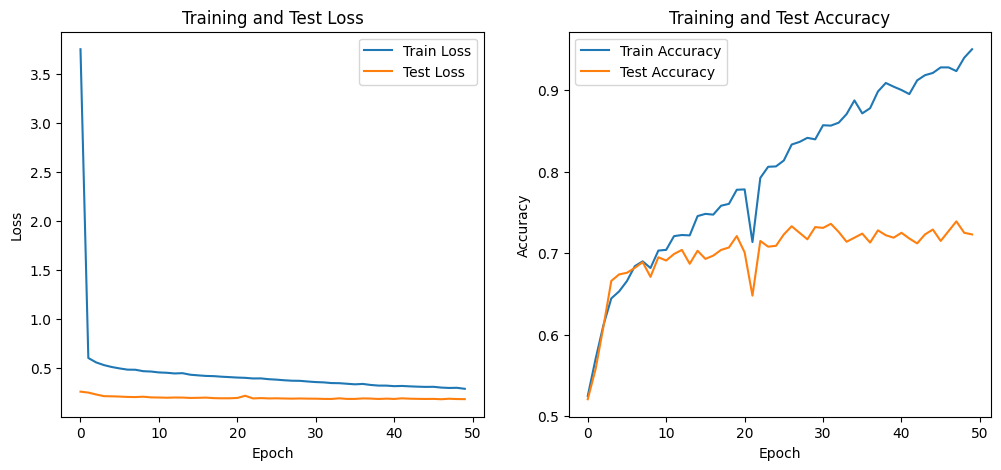

In [ ]:
# === Imports ===
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# === Define Transformations ===
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop((125, 94), scale=(0.8, 1.0)),
])

basic_transform = transforms.ToTensor()

# === Contrastive Loss ===
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        distances = nn.functional.pairwise_distance(output1, output2)
        loss = (label) * torch.pow(distances, 2) + \
               (1 - label) * torch.pow(torch.clamp(self.margin - distances, min=0.0), 2)
        return loss.mean()

# === Siamese Dataset ===
class SiameseDatasetWithAugmentation(Dataset):
    def __init__(self, pairs, labels, transform=None, augmentation=None, is_train=True):
        self.pairs = pairs
        self.labels = labels
        self.transform = transform
        self.augmentation = augmentation
        self.is_train = is_train

    def __getitem__(self, index):
        img1, img2 = self.pairs[index]
        label = self.labels[index]

        if isinstance(img1, torch.Tensor):
            img1 = transforms.ToPILImage()(img1)
        else:
            img1 = Image.fromarray(img1)

        if isinstance(img2, torch.Tensor):
            img2 = transforms.ToPILImage()(img2)
        else:
            img2 = Image.fromarray(img2)

        if self.is_train and self.augmentation:
            img1_aug = self.augmentation(img1)
            img2_aug = self.augmentation(img2)
        else:
            img1_aug = img1
            img2_aug = img2

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            img1_aug = self.transform(img1_aug)
            img2_aug = self.transform(img2_aug)

        label = torch.tensor(label, dtype=torch.float32)

        return img1, img2, img1_aug, img2_aug, label

    def __len__(self):
        return len(self.pairs)

# === Siamese Network ===
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=10),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=7),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 128, kernel_size=4),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=4),
            nn.ReLU(),
        )

        dummy_input = torch.randn(1, 1, 125, 94)
        cnn_output = self.cnn(dummy_input)
        flattened_size = cnn_output.view(-1).size(0)

        self.fc = nn.Sequential(
            nn.Linear(flattened_size, 4096),
            nn.Sigmoid()
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward_one(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def forward(self, x1, x2):
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)
        return out1, out2

# === Evaluation Function ===
def evaluate_accuracy(model, data_loader, device, threshold=0.5):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for img1, img2, _, _, label in data_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)

            output1, output2 = model(img1, img2)
            distances = torch.nn.functional.pairwise_distance(output1, output2)

            preds = (distances < threshold).float()
            correct += (preds == label).sum().item()
            total += label.size(0)

    accuracy = correct / total
    return accuracy

# === Train Function with Accuracy Tracking ===
def train_with_augmentation(
    model, train_loader, test_loader, criterion, optimizer, device, num_epochs=50, threshold=0.5
):
    history = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': []}

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for img1, img2, img1_aug, img2_aug, label in train_loader:
            img1, img2, img1_aug, img2_aug, label = (
                img1.to(device), img2.to(device), img1_aug.to(device), img2_aug.to(device), label.to(device)
            )
            # Forward and losses
            optimizer.zero_grad()


            output_aug1, output_1 = model(img1_aug, img1)
            output_aug2, output_2 = model(img2_aug, img2)

            loss_augmented_1 = criterion(output_aug1,output_1, torch.ones_like(label))            
            # Original forward pass - for 2 images
            loss_original = criterion(output_1, output_2, label)
            # Augmented forward pass - for same images
            loss_augmented_2 = criterion(output_aug2, output_2, torch.ones_like(label))
            # Augmented forward pass - for same images
            loss_augmented_3 = criterion(output_aug2, output_aug1, label)

            loss = loss_original + loss_augmented_1 + loss_augmented_2 + loss_augmented_3 
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * label.size(0)

        train_loss = total_loss / len(train_loader.dataset)
        history['train_loss'].append(train_loss)

        # Evaluate train and test accuracies
        train_acc = evaluate_accuracy(model, train_loader, device, threshold)
        test_acc = evaluate_accuracy(model, test_loader, device, threshold)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

        # Validation Loss
        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for img1, img2, _, _, label in test_loader:
                img1, img2, label = img1.to(device), img2.to(device), label.to(device)

                output1, output2 = model(img1, img2)
                loss = criterion(output1, output2, label)
                total_test_loss += loss.item() * label.size(0)

        test_loss = total_test_loss / len(test_loader.dataset)
        history['test_loss'].append(test_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f} Test Loss: {test_loss:.4f} "
              f"Train Acc: {train_acc*100:.2f}% Test Acc: {test_acc*100:.2f}%")

    return history

# === Main Setup ===
# Suppose you already have these:
# train_pairs, train_labels, test_pairs, test_labels

train_dataset = SiameseDatasetWithAugmentation(
    train_pairs, train_labels, transform=basic_transform, augmentation=augmentation_transforms, is_train=True
)
test_dataset = SiameseDatasetWithAugmentation(
    test_pairs, test_labels, transform=basic_transform, augmentation=None, is_train=False
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork().to(device)
criterion = ContrastiveLoss(margin=1.0)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

# Train
history = train_with_augmentation(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=50)

# Final Test Accuracy
test_accuracy = evaluate_accuracy(model, test_loader, device, threshold=0.5)
print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['test_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss')

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['test_acc'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Test Accuracy')

plt.show()


In [11]:
# === Imports ===
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# === Define Transformations ===
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop((125, 94), scale=(0.8, 1.0)),
])

basic_transform = transforms.ToTensor()

# === Contrastive Loss ===
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        distances = nn.functional.pairwise_distance(output1, output2)
        loss = (label) * torch.pow(distances, 2) + \
               (1 - label) * torch.pow(torch.clamp(self.margin - distances, min=0.0), 2)
        return loss.mean()

# === Siamese Dataset ===
class SiameseDatasetWithAugmentation(Dataset):
    def __init__(self, pairs, labels, transform=None, augmentation=None, is_train=True):
        self.pairs = pairs
        self.labels = labels
        self.transform = transform
        self.augmentation = augmentation
        self.is_train = is_train

    def __getitem__(self, index):
        img1, img2 = self.pairs[index]
        label = self.labels[index]

        if isinstance(img1, torch.Tensor):
            img1 = transforms.ToPILImage()(img1)
        else:
            img1 = Image.fromarray(img1)

        if isinstance(img2, torch.Tensor):
            img2 = transforms.ToPILImage()(img2)
        else:
            img2 = Image.fromarray(img2)

        if self.is_train and self.augmentation:
            img1_aug = self.augmentation(img1)
            img2_aug = self.augmentation(img2)
        else:
            img1_aug = img1
            img2_aug = img2

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            img1_aug = self.transform(img1_aug)
            img2_aug = self.transform(img2_aug)

        label = torch.tensor(label, dtype=torch.float32)

        return img1, img2, img1_aug, img2_aug, label

    def __len__(self):
        return len(self.pairs)

# === Siamese Network ===
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=10),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=7),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 128, kernel_size=4),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=4),
            nn.ReLU(),
        )

        dummy_input = torch.randn(1, 1, 125, 94)
        cnn_output = self.cnn(dummy_input)
        flattened_size = cnn_output.view(-1).size(0)

        self.fc = nn.Sequential(
            nn.Linear(flattened_size, 4096),
            nn.Sigmoid()
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward_one(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def forward(self, x1, x2):
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)
        return out1, out2

# === Evaluation Function ===
def evaluate_accuracy(model, data_loader, device, threshold=0.5):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for img1, img2, _, _, label in data_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)

            output1, output2 = model(img1, img2)
            distances = torch.nn.functional.pairwise_distance(output1, output2)

            preds = (distances < threshold).float()
            correct += (preds == label).sum().item()
            total += label.size(0)

    accuracy = correct / total
    return accuracy

# === Train Function with Accuracy Tracking ===
def train_with_augmentation(
    model, train_loader, test_loader, criterion, optimizer, device, num_epochs=50, threshold=0.5
):
    history = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': []}

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for img1, img2, img1_aug, img2_aug, label in train_loader:
            img1, img2, img1_aug, img2_aug, label = (
                img1.to(device), img2.to(device), img1_aug.to(device), img2_aug.to(device), label.to(device)
            )
            # Forward and losses
            optimizer.zero_grad()


            output_aug1, output_1 = model(img1_aug, img1)
            output_aug2, output_2 = model(img2_aug, img2)

            loss_augmented_1 = criterion(output_aug1,output_1, torch.ones_like(label))            
            # Original forward pass - for 2 images
            loss_original = criterion(output_1, output_2, label)
            # Augmented forward pass - for same images
            # loss_augmented_2 = criterion(output_aug2, output_2, torch.ones_like(label))
            # Augmented forward pass - for same images
            loss_augmented_3 = criterion(output_aug2, output_aug1, label)

            loss = loss_original + loss_augmented_1 + loss_augmented_3 
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * label.size(0)

        train_loss = total_loss / len(train_loader.dataset)
        history['train_loss'].append(train_loss)

        # Evaluate train and test accuracies
        train_acc = evaluate_accuracy(model, train_loader, device, threshold)
        test_acc = evaluate_accuracy(model, test_loader, device, threshold)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

        # Validation Loss
        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for img1, img2, _, _, label in test_loader:
                img1, img2, label = img1.to(device), img2.to(device), label.to(device)

                output1, output2 = model(img1, img2)
                loss = criterion(output1, output2, label)
                total_test_loss += loss.item() * label.size(0)

        test_loss = total_test_loss / len(test_loader.dataset)
        history['test_loss'].append(test_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f} Test Loss: {test_loss:.4f} "
              f"Train Acc: {train_acc*100:.2f}% Test Acc: {test_acc*100:.2f}%")

    return history

# === Main Setup ===
# Suppose you already have these:
# train_pairs, train_labels, test_pairs, test_labels

train_dataset = SiameseDatasetWithAugmentation(
    train_pairs, train_labels, transform=basic_transform, augmentation=augmentation_transforms, is_train=True
)
test_dataset = SiameseDatasetWithAugmentation(
    test_pairs, test_labels, transform=basic_transform, augmentation=None, is_train=False
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork().to(device)
criterion = ContrastiveLoss(margin=1.0)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

# Train
history = train_with_augmentation(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=25)

# Final Test Accuracy
test_accuracy = evaluate_accuracy(model, test_loader, device, threshold=0.5)
print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch [1/25] Train Loss: 4.1903 Test Loss: 0.2417 Train Acc: 55.77% Test Acc: 55.60%
Epoch [2/25] Train Loss: 0.5607 Test Loss: 0.2373 Train Acc: 57.86% Test Acc: 58.00%
Epoch [3/25] Train Loss: 0.5175 Test Loss: 0.2162 Train Acc: 64.05% Test Acc: 65.50%
Epoch [4/25] Train Loss: 0.4899 Test Loss: 0.2030 Train Acc: 67.55% Test Acc: 68.90%
Epoch [5/25] Train Loss: 0.4763 Test Loss: 0.2084 Train Acc: 66.77% Test Acc: 65.50%
Epoch [6/25] Train Loss: 0.4569 Test Loss: 0.2017 Train Acc: 68.45% Test Acc: 68.40%
Epoch [7/25] Train Loss: 0.4583 Test Loss: 0.1925 Train Acc: 73.23% Test Acc: 71.10%
Epoch [8/25] Train Loss: 0.4473 Test Loss: 0.1924 Train Acc: 73.09% Test Acc: 70.50%
Epoch [9/25] Train Loss: 0.4375 Test Loss: 0.1942 Train Acc: 73.82% Test Acc: 69.20%
Epoch [10/25] Train Loss: 0.4346 Test Loss: 0.1932 Train Acc: 74.32% Test Acc: 71.20%
Epoch [11/25] Train Loss: 0.4188 Test Loss: 0.1864 Train Acc: 76.77% Test Acc: 71.90%
Epoch [12/25] Train Loss: 0.4149 Test Loss: 0.1878 Train Acc: 7